# BraTS2020 **2D** Segmentation

---
## 1. Loading data and preprocessing
### 1.1 Loading data and preprocessing
**Pipeline**
1. Group all `.h5` slices by patient (`volume_<vid>_slice_<sid>.h5`)
2. Patient-wise subset & train/val/test split (avoids leakage)
3. 2D preprocessing: drop all-zero masks, percentile normalization, center pad/crop

In [2]:
import os, re, random, h5py, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
from scipy.spatial.distance import cdist

DATA_ROOT = Path('./brats2020-training-data/BraTS2020_training_data/content/data')
OUTPUT_DIR = Path('./outputs_localGPU'); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBSET_FRACTION = 0.5 # 0.2 # 0.5
SEED = 42
BATCH_SIZE = 64
EPOCHS = 25
LR = 1e-4
IMG_SIZE = (240, 240)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
print(f'Using device: {DEVICE}')
print(f'Reading slices from: {DATA_ROOT.resolve()}')


Using device: cuda
Reading slices from: /home/holly520/Code_CSE/DIT698_DL/project/BraTS_hightlight/brats2020-training-data/BraTS2020_training_data/content/data


In [2]:
H5_RE = re.compile(r'^volume_(\d+)_slice_(\d+)\.h5$', re.IGNORECASE)

def group_by_volume(root: Path):
    groups = defaultdict(list)
    for p in root.glob('*.h5'):
        m = H5_RE.fullmatch(p.name)
        if not m:
            continue
        vid = int(m.group(1)); sid = int(m.group(2))
        groups[vid].append((sid, p.resolve()))
    grouped = {vid: [path for sid, path in sorted(items, key=lambda x: x[0])]
               for vid, items in sorted(groups.items(), key=lambda kv: kv[0])}
    return grouped

groups = group_by_volume(DATA_ROOT)
print(f'Found {len(groups)} patients. Example IDs:', list(groups.keys())[:8])
total_slices = sum(len(v) for v in groups.values())
print(f'Total slices discovered: {total_slices}')


Found 369 patients. Example IDs: [1, 2, 3, 4, 5, 6, 7, 8]
Total slices discovered: 57195


In [3]:
all_vids = list(groups.keys())
random.Random(SEED).shuffle(all_vids)
subset_n = max(1, int(len(all_vids) * SUBSET_FRACTION))
subset_vids = sorted(all_vids[:subset_n])

train_vids, test_vids = train_test_split(subset_vids, test_size=0.2, random_state=SEED)
train_vids, val_vids  = train_test_split(train_vids, test_size=0.2, random_state=SEED)

def gather_paths(vid_list):
    out = []
    for vid in vid_list:
        out.extend(groups[vid])
    return out

train_paths = gather_paths(train_vids)
val_paths   = gather_paths(val_vids)
test_paths  = gather_paths(test_vids)

print(f'Subset patients: {len(subset_vids)} | train: {len(train_vids)}, val: {len(val_vids)}, test: {len(test_vids)}')
print(f'Slices -> train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}')


Subset patients: 184 | train: 117, val: 30, test: 37
Slices -> train: 18135, val: 4650, test: 5735


In [4]:
import h5py, numpy as np

def read_h5(path: Path):
    """
    Expect:
      image: (H, W, 4) or (4, H, W)  -> returns (4, H, W) float32
      mask:  (H, W, 3) one-hot for (Necrosis, Edema, Enhancing)
             -> returns (H, W) int64 with labels: 0=BG, 1=Necrosis, 2=Edema, 3=Enhancing
    """
    # with h5py.File(path, "r") as f:
    with h5py.File(path, "r", libver="latest", swmr=True) as f:
        img = f["image"][()]
        # to channels-first (4, H, W)
        if img.ndim == 3 and img.shape[-1] in (3,4):
            img = np.moveaxis(img, -1, 0)
        elif img.ndim == 2:
            img = img[None, ...]
        elif img.ndim == 3 and img.shape[0] in (3,4):
            pass
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")

        m = f["mask"][()]  # (H, W, 3) one-hot
        if m.ndim != 3 or m.shape[-1] != 3:
            raise ValueError(f"Expect mask (H,W,3) one-hot, got {m.shape}")

        # background channel = 1 - any(foreground)
        bg = (m <= 0).all(axis=-1, keepdims=True).astype(np.uint8)  # (H,W,1)
        # stack as [BG, Necrosis, Edema, Enhancing]
        four = np.concatenate([bg, (m > 0).astype(np.uint8)], axis=-1)  # (H,W,4)
        # to class indices 0..3
        cls = np.argmax(four, axis=-1).astype(np.int64)  # (H,W)

        return img.astype(np.float32), cls  # (4,H,W), (H,W) int64


def percentile_normalize(img, lower=0.5, upper=99.5, eps=1e-6):
    # img: (C,H,W)
    out = np.empty_like(img, dtype=np.float32)
    for c in range(img.shape[0]):
        lo = np.percentile(img[c], lower); hi = np.percentile(img[c], upper)
        out[c] = np.clip((img[c]-lo)/(hi-lo+eps), 0, 1)
    return out

def _pad2d_or_3d(arr, ph, pw):
    if arr.ndim == 3:  # (C,H,W)
        return np.pad(arr, ((0,0),(ph//2, ph-ph//2),(pw//2, pw-pw//2)), mode="constant")
    if arr.ndim == 2:  # (H,W)
        return np.pad(arr, ((ph//2, ph-ph//2),(pw//2, pw-pw//2)), mode="constant")
    raise ValueError(f"Unsupported ndim={arr.ndim}")

def center_pad_crop(img, mask, size=(240,240)):
    H, W = img.shape[1], img.shape[2]; th, tw = size
    ph, pw = max(0, th-H), max(0, tw-W)
    if ph>0 or pw>0:
        img  = _pad2d_or_3d(img,  ph, pw)
        mask = _pad2d_or_3d(mask, ph, pw)
    H2, W2 = img.shape[1], img.shape[2]
    sy, sx = (H2-th)//2, (W2-tw)//2
    return img[:, sy:sy+th, sx:sx+tw], mask[sy:sy+th, sx:sx+tw]


In [5]:
from torch.utils.data import Dataset, DataLoader

class BraTS2DDataset(Dataset):
    """
    Lazy-loading dataset:
      - Keep only file paths in __init__
      - Read/normalize/pad-crop on-the-fly in __getitem__
      - Optionally drop slices whose mask is all background
    """
    def __init__(self, paths, drop_all_zero=True, size=(240, 240)):
        self.paths = list(paths)
        self.drop_all_zero = drop_all_zero
        self.size = size

    def __len__(self):
        return len(self.paths)

    def _load_one(self, p: Path):
        # read from disk
        img, cls = read_h5(p)                 # img: (4,H,W)  cls: (H,W) int
        # optional drop: keep only slices with any foreground
        if self.drop_all_zero and cls.max() == 0:
            return None
        # preprocessing
        img = percentile_normalize(img)
        img, cls = center_pad_crop(img, cls, size=self.size)
        # to tensors
        x = torch.from_numpy(img).float()     # (C,H,W)
        y = torch.from_numpy(cls).long()      # (H,W)
        return x, y, p.name.replace('.h5','')

    def __getitem__(self, idx):
        p = self.paths[idx]
        sample = self._load_one(p)

        # If this slice was dropped due to all-zero mask, fallback to a nearby one
        if sample is None:
            # linear probing to find the next valid slice
            j = (idx + 1) % len(self.paths)
            while True:
                sample = self._load_one(self.paths[j])
                if sample is not None or j == idx:
                    break
                j = (j + 1) % len(self.paths)

            # as a last resort (all zero), create a dummy empty slice (rare)
            if sample is None:
                img, cls = read_h5(self.paths[idx])
                img = percentile_normalize(img)
                img, cls = center_pad_crop(img, cls, size=self.size)
                sample = (torch.from_numpy(img).float(),
                          torch.from_numpy(cls).long(),
                          self.paths[idx].name.replace('.h5',''))

        return sample


num_workers = min(8, os.cpu_count() or 4)
# num_workers = 0  # set >0 after debugging

def make_loader_kwargs(num_workers: int):
    if num_workers == 0:
        return dict(num_workers=0, pin_memory=False)  # single-process, no prefetch/persistent
    else:
        return dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2,
        )

common_kwargs = make_loader_kwargs(num_workers)

train_ds = BraTS2DDataset(train_paths, drop_all_zero=True,  size=IMG_SIZE)
val_ds   = BraTS2DDataset(val_paths,   drop_all_zero=True,  size=IMG_SIZE)
test_ds  = BraTS2DDataset(test_paths,  drop_all_zero=False, size=IMG_SIZE)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  **common_kwargs)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, **common_kwargs)
test_loader  = DataLoader(test_ds,  batch_size=1,          shuffle=False, **common_kwargs)


---
### 1.2 Train/Evaluate Visualize

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def viz_overlays(
    ds,
    model,
    device="cpu",
    n=6,
    rows=None,
    cols=None,
    base_channel=1,                 # which modality to display as grayscale (e.g., 1 = T1Gd)
    class_colors=None,              # dict like {1:'y', 2:'c', 3:'m'}
    gt_linestyle="solid",
    pred_linestyle="dashed",
    linewidth=1.2,
    figsize=(10, 6),
    seed=None,
):
    if class_colors is None:
        class_colors = {1: "y", 2: "c", 3: "m"}

    if seed is not None:
        np.random.seed(seed)

    if rows is None or cols is None:
        rows = rows or 2
        cols = cols or int(np.ceil(n / rows))

    model.eval()
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.atleast_1d(axes).ravel()

    with torch.no_grad():
        for i in range(min(n, len(axes))):
            idx = np.random.randint(len(ds))
            x, y, name = ds[idx]                # x: (C,H,W), y: (H,W)
            xb = x[None].to(device)             # (1,C,H,W)

            logits = model(xb)                  # (1,4,H,W)
            pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)[0].cpu().numpy()
            gt   = y.cpu().numpy() if torch.is_tensor(y) else y

            # choose background channel safely
            bch = base_channel
            if bch >= x.shape[0]:
                bch = 0
            base = x.numpy()[bch] if torch.is_tensor(x) else x[bch]

            ax = axes[i]
            ax.imshow(base, cmap="gray")

            # draw GT (solid) and Pred (dashed) for each foreground class
            for c in (1, 2, 3):
                ax.contour((gt==c).astype(np.uint8),   levels=[0.5],
                           colors=class_colors.get(c, "w"), linewidths=linewidth,
                           linestyles=gt_linestyle)
                ax.contour((pred==c).astype(np.uint8), levels=[0.5],
                           colors=class_colors.get(c, "w"), linewidths=linewidth,
                           linestyles=pred_linestyle)

            ax.set_title(str(name))
            ax.axis("off")

    plt.suptitle("Solid = GT  |  Dashed = Pred  (1: Necrosis, 2: Edema, 3: Enhancing)")
    plt.tight_layout()
    plt.show()

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def viz_overlays_pro(
    ds,
    model,
    device="cpu",
    n=6,
    samples_per_row=3,            # how many cases per row (each case = 1 or 2 panels)
    base_channel=1,               # modality to display as grayscale
    show_error=False,             # also show TP/FP/FN
    panel_size=3.2,               # inches per panel (width ~= height)
    class_names={1:"Necrosis", 2:"Edema", 3:"Enhancing"},
    class_colors={1:"#ffcc00", 2:"#00c5d8", 3:"#cc66ff"},  # GT fill colors
    pred_edge_colors=None,        # None -> reuse fill colors
    gt_alpha=0.35,
    pred_lw=2.6,
    pred_ls="dashed",
    seed=None,
    suptitle="GT = filled  |  Pred = dashed outline",
):
    """
    Compact overlay visualization for multiclass segmentation.
      - 0 = background, 1..3 = foreground classes.
      - If `show_error=True`, each sample occupies two panels: [overlay | error].
    """
    if seed is not None:
        np.random.seed(seed)
    if pred_edge_colors is None:
        pred_edge_colors = {k: class_colors[k] for k in class_colors}

    model.eval()

    # how many panels per sample
    panels_per_sample = 2 if show_error else 1

    # grid sizes
    rows = int(np.ceil(n / samples_per_row))
    cols = samples_per_row * panels_per_sample

    # figure size (proportional to number of panels)
    fig_w = panel_size * cols
    fig_h = panel_size * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = np.atleast_2d(axes)
    axes = axes.reshape(rows, cols)

    # helper: percentile normalization for the grayscale background
    def _norm(x, lo=1.0, hi=99.0, eps=1e-6):
        p1, p99 = np.percentile(x, lo), np.percentile(x, hi)
        x = (x - p1) / (p99 - p1 + eps)
        return np.clip(x, 0, 1)

    with torch.no_grad():
        for i in range(n):
            r = i // samples_per_row
            c0 = (i % samples_per_row) * panels_per_sample
            ax = axes[r, c0]

            # pick a random sample
            x, y, name = ds[np.random.randint(len(ds))]
            xb = x[None].to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1)[0].cpu().numpy()
            gt   = y.cpu().numpy() if torch.is_tensor(y) else y

            # choose background modality & normalize for better contrast
            bch  = base_channel if base_channel < x.shape[0] else 0
            base = x.numpy()[bch] if torch.is_tensor(x) else x[bch]
            base = _norm(base)

            # ---- Overlay panel
            ax.imshow(base, cmap="gray", interpolation="nearest")
            for cc in (1, 2, 3):
                gt_mask = (gt == cc).astype(np.uint8)
                if gt_mask.any():
                    ax.contourf(gt_mask, levels=[0.5, 1.5],
                                colors=[class_colors[cc]], alpha=gt_alpha, antialiased=False)
                pred_mask = (pred == cc).astype(np.uint8)
                if pred_mask.any():
                    ax.contour(pred_mask, levels=[0.5],
                               colors=[pred_edge_colors[cc]],
                               linewidths=pred_lw, linestyles=pred_ls, antialiased=False)
            ax.set_title(str(name), fontsize=10)
            ax.set_axis_off()
            ax.set_aspect("equal", adjustable="box")

            # ---- Error panel (optional)
            if show_error:
                ax2 = axes[r, c0 + 1]
                tp = (pred == gt) & (gt > 0)              # green
                fp = (pred > 0) & (gt == 0)               # red
                fn = (pred == 0) & (gt > 0)               # blue
                err = np.zeros((*gt.shape, 3), dtype=np.float32)
                err[tp] = (0.0, 0.9, 0.0)
                err[fp] = (1.0, 0.1, 0.1)
                err[fn] = (0.1, 0.6, 1.0)
                ax2.imshow(base, cmap="gray", interpolation="nearest")
                ax2.imshow(err, alpha=0.45, interpolation="nearest")
                ax2.set_title("Error (TP/FP/FN)", fontsize=10)
                ax2.set_axis_off()
                ax2.set_aspect("equal", adjustable="box")

    # tighten spacing; leave a small room for legend/suptitle
    plt.subplots_adjust(wspace=0.02, hspace=0.15)

    # single legend for the whole figure
    legend = []
    for c, nm in class_names.items():
        legend.append(Patch(facecolor=class_colors[c], edgecolor="none", alpha=gt_alpha, label=f"GT {nm}"))
        legend.append(Line2D([0],[0], color=pred_edge_colors[c], lw=pred_lw, linestyle=pred_ls, label=f"Pred {nm}"))
    if show_error:
        legend += [
            Patch(facecolor=(0,0.9,0), edgecolor='none', alpha=0.6, label="TP"),
            Patch(facecolor=(1,0.1,0.1), edgecolor='none', alpha=0.6, label="FP"),
            Patch(facecolor=(0.1,0.6,1), edgecolor='none', alpha=0.6, label="FN"),
        ]
    fig.legend(handles=legend, loc="upper center", ncol=5 if show_error else 3,
               bbox_to_anchor=(0.5, 1.02), frameon=False, fontsize=9)
    fig.suptitle(suptitle, y=1.06, fontsize=11)
    plt.tight_layout(rect=(0, 0, 1, 0.98))
    plt.show()


In [8]:
import numpy as np
import pandas as pd
import re
import torch

def dice_iou_binary(p, t, eps=1e-6):
    inter = (p & t).sum()
    union = (p | t).sum()
    dice = (2*inter + eps) / (p.sum() + t.sum() + eps)
    iou  = (inter + eps) / (union + eps)
    return float(dice), float(iou)

def evaluate_multiclass(
    loader,
    model,
    device="cpu",
    num_classes=4,
    add_overall_mean: bool = True,
    overall_label: str = "Overall_Mean",
    save_csv_dir = None,                  # e.g., OUTPUT_DIR Path; saves 2 CSVs if not None
    model_name=None
):
    """
    Evaluate a multiclass model on a DataLoader.

    Returns:
      per_slice_df : metrics per slice
      per_vol_df   : metrics aggregated per volume (with an extra 'Overall_Mean' row if add_overall_mean=True)
      overall_row  : dict of overall mean metrics (or None if add_overall_mean=False)
    """
    model.eval()
    rows = []
    with torch.no_grad():
        for x, y, name in loader:
            x = x.to(device)        # (1, C, H, W)
            y = y.to(device)        # (1, H, W) long
            logits = model(x)       # (1, num_classes, H, W)

            pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)[0].cpu().numpy()
            gt   = y[0].cpu().numpy()

            metrics = {"id": name[0]}
            dices, ious = [], []
            for c, cname in zip([1, 2, 3], ["Necrosis", "Edema", "Enhancing"]):
                p = (pred == c).astype(np.uint8)
                t = (gt   == c).astype(np.uint8)
                d, i = dice_iou_binary(p, t)
                metrics[f"dice_{cname}"] = d
                metrics[f"iou_{cname}"]  = i
                dices.append(d); ious.append(i)

            metrics["dice_FG_mean"] = float(np.mean(dices))
            metrics["iou_FG_mean"]  = float(np.mean(ious))
            rows.append(metrics)

    per_slice_df = pd.DataFrame(rows)

    # ---- aggregate per volume
    def volid(s):
        m = re.match(r"(volume_\d+)_slice_\d+$", s)
        return m.group(1) if m else s

    per_slice_df["volume_id"] = per_slice_df["id"].map(volid)
    per_vol_df = per_slice_df.groupby("volume_id", as_index=False).mean(numeric_only=True)

    overall_row = None
    if add_overall_mean and len(per_vol_df) > 0:
        # compute overall mean across all numeric columns
        overall_row = per_vol_df.mean(numeric_only=True).to_dict()
        overall_row["volume_id"] = overall_label
        # append as the last row
        per_vol_df = pd.concat([per_vol_df, pd.DataFrame([overall_row])], ignore_index=True)

    # optional: save CSVs
    if save_csv_dir is not None:
        (save_csv_dir / f"{model_name}_metrics_mc_per_slice.csv").write_text(per_slice_df.to_csv(index=False))
        (save_csv_dir / f"{model_name}_metrics_mc_per_volume.csv").write_text(per_vol_df.to_csv(index=False))

    return per_slice_df, per_vol_df, overall_row

In [9]:
import numpy as np

def viz_compare(val_ds, model1, model2, device="cpu", n=6, model1_name=None, model2_name=None):
    """
    Visualize UNet vs Encoder–Decoder on the same slices.
    GT: solid contours, UNet: dashed, EncDec: dotted.
    """
    model1.eval(); model2.eval()
    rows, cols = (n + 2)//3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    axes = axes.ravel()
    colors = {1:"y", 2:"c", 3:"m"}

    with torch.no_grad():
        for i in range(min(n, len(axes))):
            idx = np.random.randint(len(val_ds))
            x, y, name = val_ds[idx]
            base_img = x.numpy()[1] if x.shape[0] > 1 else x.numpy()[0]

            xb = x[None].to(device)
            pu = torch.argmax(torch.softmax(model1(xb),  dim=1), dim=1)[0].cpu().numpy()
            pe = torch.argmax(torch.softmax(model2(xb),    dim=1), dim=1)[0].cpu().numpy()
            gt = y.numpy()

            ax = axes[i]; ax.imshow(base_img, cmap="gray")
            for c in (1,2,3):
                ax.contour((gt==c).astype(np.uint8), levels=[0.5], colors=colors[c], linewidths=1.2)                 # GT (solid)
                ax.contour((pu==c).astype(np.uint8), levels=[0.5], colors=colors[c], linewidths=1.2, linestyles="dashed") # UNet
                ax.contour((pe==c).astype(np.uint8), levels=[0.5], colors=colors[c], linewidths=1.2, linestyles="dotted") # EncDec
            ax.set_title(f"{name} (solid=GT, dashed={model1_name}, dotted={model2_name})")
            ax.axis("off")
    plt.tight_layout(); plt.show()

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def viz_compare_triplet(
    ds,
    model1, model2,
    device="cpu",
    n=6,
    samples_per_row=3,
    base_channel=1,
    class_names={1:"Necrosis", 2:"Edema", 3:"Enhancing"},
    # GT light fills
    gt_colors={1:"#ffe8a6", 2:"#bff6fb", 3:"#efd3ff"},
    gt_alpha=0.30,
    gt_edge=True,
    # UNet (model1) warm edges
    m1_colors={1:"#ffb000", 2:"#ff6f00", 3:"#a64cff"},
    # TL/EncDec (model2) cool edges
    m2_colors={1:"#007a99", 2:"#00a7b7", 3:"#5b6cff"},
    # line styles/widths
    m1_ls="--", m2_ls=":",
    m1_lw=3.0, m2_lw=3.0,
    # two-pass halo parameters
    m1_halo_color="black", m2_halo_color="white",
    m1_halo_extra=2.2, m2_halo_extra=2.2,
    panel_size=3.0,
    seed=None,
    title1="UNet", title2="TL"
):
    """
    GT = light filled polygons (+optional thin white edge).
    Model1 = dashed warm outline with black halo (two-pass).
    Model2 = dotted cool outline with white halo (two-pass).
    """
    if seed is not None:
        np.random.seed(seed)
    model1.eval(); model2.eval()

    rows = int(np.ceil(n / samples_per_row))
    cols = samples_per_row
    fig, axes = plt.subplots(rows, cols, figsize=(panel_size*cols, panel_size*rows))
    axes = np.atleast_1d(axes).ravel()

    def norm01(arr, lo=1, hi=99, eps=1e-6):
        p1, p99 = np.percentile(arr, lo), np.percentile(arr, hi)
        return np.clip((arr - p1) / (p99 - p1 + eps), 0, 1)

    with torch.no_grad():
        for i in range(min(n, len(axes))):
            idx = np.random.randint(len(ds))
            x, y, name = ds[idx]                   # x:(C,H,W), y:(H,W)
            xb = x[None].to(device)
            p1 = torch.argmax(model1(xb), dim=1)[0].cpu().numpy()
            p2 = torch.argmax(model2(xb), dim=1)[0].cpu().numpy()
            gt = y.cpu().numpy() if torch.is_tensor(y) else y

            ch   = base_channel if base_channel < x.shape[0] else 0
            base = x.numpy()[ch] if torch.is_tensor(x) else x[ch]
            base = norm01(base)

            ax = axes[i]
            ax.imshow(base, cmap="gray", interpolation="nearest")

            for c in (1,2,3):
                gtm = (gt==c).astype(np.uint8)
                if gtm.any():
                    ax.contourf(gtm, levels=[0.5,1.5],
                                colors=[gt_colors[c]], alpha=gt_alpha, antialiased=False, zorder=1)
                    if gt_edge:
                        ax.contour(gtm, levels=[0.5], colors=["#ffffff"],
                                   linewidths=0.8, linestyles="solid", antialiased=False, zorder=2)

                # --- model1 (UNet): HALO pass (behind), then COLOR pass (front)
                m1m = (p1==c).astype(np.uint8)
                if m1m.any():
                    ax.contour(m1m, levels=[0.5], colors=[m1_halo_color],
                               linewidths=m1_lw + m1_halo_extra, linestyles=m1_ls,
                               antialiased=False, zorder=4)   # halo
                    ax.contour(m1m, levels=[0.5], colors=[m1_colors[c]],
                               linewidths=m1_lw, linestyles=m1_ls,
                               antialiased=False, zorder=5)   # colored edge

                # --- model2 (TL): HALO pass (behind), then COLOR pass (front)
                m2m = (p2==c).astype(np.uint8)
                if m2m.any():
                    ax.contour(m2m, levels=[0.5], colors=[m2_halo_color],
                               linewidths=m2_lw + m2_halo_extra, linestyles=m2_ls,
                               antialiased=False, zorder=6)   # halo
                    ax.contour(m2m, levels=[0.5], colors=[m2_colors[c]],
                               linewidths=m2_lw, linestyles=m2_ls,
                               antialiased=False, zorder=7)   # colored edge

            ax.set_title(str(name), fontsize=12, pad=8)
            ax.set_axis_off(); ax.set_aspect("equal", adjustable="box")

    plt.subplots_adjust(wspace=0.03, hspace=0.18)

    # row A: classes via GT color
    palette = [Patch(facecolor=gt_colors[c], edgecolor="none", alpha=gt_alpha,
                    label=class_names[c]) for c in (1,2,3)]
    legA = fig.legend(
        handles=palette,                    # <--- use keyword
        title="Classes (GT fill)",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=len(palette),
        frameon=False,
        fontsize=10,
        title_fontsize=10,
    )
    fig.add_artist(legA)

    # row B: style key
    style = [
        Line2D([0],[0], color="#333", lw=m1_lw+m1_halo_extra, ls=m1_ls, label=f"{title1} (dashed)"),
        Line2D([0],[0], color="#999", lw=m2_lw+m2_halo_extra, ls=m2_ls, label=f"{title2} (dotted)"),
        Patch(facecolor="#d9d9d9", edgecolor="none", alpha=0.6, label="GT = filled"),
    ]
    fig.legend(
        handles=style,                      # <--- use keyword
        loc="upper center",
        bbox_to_anchor=(0.5, 0.965),
        ncol=len(style),
        frameon=False,
        fontsize=10,
    )

    plt.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()



In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def _percentile_norm(img, lo=1.0, hi=99.0, eps=1e-6):
    p1, p99 = np.percentile(img, lo), np.percentile(img, hi)
    return np.clip((img - p1) / (p99 - p1 + eps), 0, 1)

def _binary_boundary(mask):
    """1-pixel boundary: mask XOR erode(mask). Works for uint8/0-1 arrays."""
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    # 4-neighborhood erosion
    from scipy.ndimage import binary_erosion
    er = binary_erosion(mask, structure=np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8), border_value=0)
    return (mask ^ er).astype(np.uint8)

def viz_compare_diagnostic(
    ds,
    model_1,
    model_2,
    device="cpu",
    n=6,
    samples_per_row=2,
    base_channel=1,
    show_overlay=True,
    show_boundaries=True,
    show_agreement=True,
    # colors
    gt_fill_colors   ={1:"#ffe9b0", 2:"#c7f5ff", 3:"#efd6ff"},   # light fills for overlay
    gt_edge_color    ="#ffffff",
    unet_edge_colors ={1:"#ff8a00", 2:"#ff4d00", 3:"#a64cff"},   # warm
    tl_edge_colors   ={1:"#008aa6", 2:"#00b1c4", 3:"#5b6cff"},   # cool
    # line styles
    unet_ls="--", tl_ls=":", unet_lw=2.8, tl_lw=2.8,
    gt_alpha=0.30, panel_size=3.1, seed=None,
    model_1_name=None, model_2_name=None
):
    """
    Triptych per slice:
      [Overlay]   GT = filled, UNet dashed (warm), TL dotted (cool)
      [Boundary]  Thin boundaries for GT(white), UNet(warm), TL(cool) -> shifts pop out
      [Agreement] Per-pixel fusion map that encodes who is positive for each class
    Assumes logits with 4 classes (0=BG, 1..3 FG) and y as (H,W) ints in [0..3].
    """
    if seed is not None: np.random.seed(seed)
    model_1.eval(); model_2.eval()

    # how many columns per sample
    cols_per_sample = int(show_overlay) + int(show_boundaries) + int(show_agreement)
    assert cols_per_sample >= 1, "Enable at least one of overlay/boundaries/agreement."

    rows = int(np.ceil(n / samples_per_row))
    cols = samples_per_row * cols_per_sample
    fig, axes = plt.subplots(rows, cols, figsize=(panel_size*cols, panel_size*rows))
    axes = np.atleast_2d(axes).reshape(rows, cols)

    # agreement color table (legend below)
    # label meaning (per pixel, per class):
    # 0: none; 1: GT only; 2: UNet only; 3: TL only; 4: UNet∩TL; 5: GT∩UNet; 6: GT∩TL; 7: ALL-3
    agree_colors = np.array([
        [0.00,0.00,0.00],  # 0 (unused background, not shown)
        [0.80,0.00,0.80],  # 1 GT only        -> magenta
        [1.00,0.55,0.00],  # 2 UNet only      -> orange
        [0.10,0.60,1.00],  # 3 TL only        -> blue
        [0.10,0.85,0.85],  # 4 UNet & TL      -> cyan
        [1.00,0.00,0.00],  # 5 GT & UNet      -> red
        [0.00,1.00,0.00],  # 6 GT & TL        -> green
        [1.00,1.00,0.00],  # 7 ALL-3          -> yellow
    ], dtype=np.float32)

    with torch.no_grad():
        for k in range(n):
            r = k // samples_per_row
            c0 = (k % samples_per_row) * cols_per_sample

            # sample & predictions
            x, y, name = ds[np.random.randint(len(ds))]
            xb = x[None].to(device)
            pu = torch.argmax(model_1(xb), dim=1)[0].cpu().numpy()
            pt = torch.argmax(model_2(xb),   dim=1)[0].cpu().numpy()
            gt = y.cpu().numpy() if torch.is_tensor(y) else y

            # background
            ch   = base_channel if base_channel < x.shape[0] else 0
            base = x.numpy()[ch] if torch.is_tensor(x) else x[ch]
            base = _percentile_norm(base)

            col_cursor = c0

            # ---------- Panel A: Overlay ----------
            if show_overlay:
                ax = axes[r, col_cursor]; col_cursor += 1
                ax.imshow(base, cmap="gray", interpolation="nearest")
                for c in (1,2,3):
                    gtm = (gt==c).astype(np.uint8)
                    if gtm.any():
                        ax.contourf(gtm, levels=[0.5,1.5], colors=[gt_fill_colors[c]],
                                    alpha=gt_alpha, antialiased=False, zorder=1)
                        ax.contour(gtm, levels=[0.5], colors=[gt_edge_color],
                                   linewidths=0.8, linestyles="solid", antialiased=False, zorder=2)
                    um = (pu==c).astype(np.uint8)
                    if um.any():
                        ax.contour(um, levels=[0.5], colors=[unet_edge_colors[c]],
                                   linewidths=unet_lw, linestyles=unet_ls, antialiased=False, zorder=4)
                    tm = (pt==c).astype(np.uint8)
                    if tm.any():
                        ax.contour(tm, levels=[0.5], colors=[tl_edge_colors[c]],
                                   linewidths=tl_lw, linestyles=tl_ls, antialiased=False, zorder=5)
                ax.set_title(str(name), fontsize=12, pad=8)
                ax.set_axis_off(); ax.set_aspect("equal", adjustable="box")

            # ---------- Panel B: Boundaries ----------
            if show_boundaries:
                ax = axes[r, col_cursor]; col_cursor += 1
                ax.imshow(base, cmap="gray", interpolation="nearest")
                for c in (1,2,3):
                    gb = _binary_boundary(gt==c)
                    ub = _binary_boundary(pu==c)
                    tb = _binary_boundary(pt==c)
                    if gb.any(): ax.imshow(np.ma.masked_where(gb==0, gb), cmap="gray", vmin=0, vmax=1,
                                           alpha=0.9, interpolation="nearest")  # white (see note below)
                    if ub.any(): ax.contour(ub, levels=[0.5], colors=[unet_edge_colors[c]],
                                            linewidths=unet_lw+1.6, linestyles=unet_ls, zorder=4)
                    if tb.any(): ax.contour(tb, levels=[0.5], colors=[tl_edge_colors[c]],
                                            linewidths=tl_lw+1.6, linestyles=tl_ls, zorder=5)
                # white GT boundary via imshow above (fast, bold); if you prefer contour:
                # ax.contour(gb, levels=[0.5], colors=[gt_edge_color], linewidths=2.0)
                ax.set_title("Boundaries", fontsize=11)
                ax.set_axis_off(); ax.set_aspect("equal", adjustable="box")

            # ---------- Panel C: Agreement / Disagreement ----------
            if show_agreement:
                ax = axes[r, col_cursor]; col_cursor += 1
                ax.imshow(base, cmap="gray", interpolation="nearest")
                H,W = gt.shape
                rgb = np.zeros((H,W,3), np.float32)
                for c in (1,2,3):
                    g = (gt==c); u=(pu==c); t=(pt==c)
                    code = (g.astype(np.uint8)<<2) | (u.astype(np.uint8)<<1) | t.astype(np.uint8)
                    # map non-zero codes to colors; zero stays background (transparent)
                    visible = code>0
                    rgb[visible] = agree_colors[code[visible]]
                ax.imshow(rgb, alpha=0.60, interpolation="nearest")
                ax.set_title("Agreement map", fontsize=11)
                ax.set_axis_off(); ax.set_aspect("equal", adjustable="box")

    # layout & legends
    plt.subplots_adjust(wspace=0.04, hspace=0.15)

    # Legend 1: classes (GT fill)
    class_handles = [Patch(facecolor=gt_fill_colors[c], edgecolor="none", alpha=gt_alpha,
                           label={1:"Necrosis",2:"Edema",3:"Enhancing"}[c]) for c in (1,2,3)]
    legA = fig.legend(handles=class_handles, title="Classes (GT fill)",
                      loc="upper center", bbox_to_anchor=(0.5, 1.02),
                      ncol=3, frameon=False, fontsize=10, title_fontsize=10)
    fig.add_artist(legA)

    # Legend 2: styles for models
    style_handles = [
        Line2D([0],[0], color="#444", lw=unet_lw, ls=unet_ls, label=f"{model_1_name} (dashed)"),
        Line2D([0],[0], color="#888", lw=tl_lw,   ls=tl_ls,   label=f"{model_2_name} (dotted)"),
        Patch(facecolor="#d9d9d9", edgecolor="none", alpha=0.6, label="GT = filled"),
    ]
    fig.legend(handles=style_handles, loc="upper center", bbox_to_anchor=(0.5, 0.965),
               ncol=3, frameon=False, fontsize=10)

    # Agreement legend
    agree_handles = [
        Patch(color=agree_colors[1], label="GT only"),
        Patch(color=agree_colors[2], label=f"{model_1_name} only"),
        Patch(color=agree_colors[3], label=f"{model_2_name} only"),
        Patch(color=agree_colors[4], label=f"{model_1_name} & {model_2_name}"),
        Patch(color=agree_colors[5], label=f"GT & {model_1_name}"),
        Patch(color=agree_colors[6], label=f"GT & {model_2_name}"),
        Patch(color=agree_colors[7], label="ALL-3"),
    ]
    fig.legend(handles=agree_handles, loc="lower center", bbox_to_anchor=(0.5, -0.02),
               ncol=4, frameon=False, fontsize=9)

    plt.tight_layout(rect=(0, 0.03, 1, 0.94))
    plt.show()


---
## 2. Train 2D Encode-Decode model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBNReLU(nn.Module):
    """(Conv -> BN -> ReLU) with same padding."""
    def __init__(self, in_ch, out_ch, k=3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, k, padding=k//2, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class EncoderDecoder2D(nn.Module):
    """
    Plain encoder–decoder:
      Encoder: repeated Conv blocks + MaxPool (downsampling)
      Bottleneck: Conv blocks
      Decoder: bilinear upsampling + Conv blocks (NO skip connections)
    """
    def __init__(self, in_ch=4, out_ch=4, base=32):
        super().__init__()
        # Encoder
        self.e1 = nn.Sequential(ConvBNReLU(in_ch, base),    ConvBNReLU(base, base))
        self.p1 = nn.MaxPool2d(2)
        self.e2 = nn.Sequential(ConvBNReLU(base, base*2),    ConvBNReLU(base*2, base*2))
        self.p2 = nn.MaxPool2d(2)
        self.e3 = nn.Sequential(ConvBNReLU(base*2, base*4),  ConvBNReLU(base*4, base*4))
        self.p3 = nn.MaxPool2d(2)
        self.e4 = nn.Sequential(ConvBNReLU(base*4, base*8),  ConvBNReLU(base*8, base*8))
        self.p4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bott = nn.Sequential(ConvBNReLU(base*8, base*16), ConvBNReLU(base*16, base*16))

        # Decoder (no skip connections)
        self.d4 = nn.Sequential(ConvBNReLU(base*16, base*8),  ConvBNReLU(base*8, base*8))
        self.d3 = nn.Sequential(ConvBNReLU(base*8,  base*4),  ConvBNReLU(base*4, base*4))
        self.d2 = nn.Sequential(ConvBNReLU(base*4,  base*2),  ConvBNReLU(base*2, base*2))
        self.d1 = nn.Sequential(ConvBNReLU(base*2,  base),    ConvBNReLU(base,   base))

        self.outc = nn.Conv2d(base, out_ch, kernel_size=1)

    def up(self, x, scale=2):  # bilinear upsample
        return F.interpolate(x, scale_factor=scale, mode="bilinear", align_corners=False)

    def forward(self, x):
        # Encode
        x1 = self.e1(x); x = self.p1(x1)
        x2 = self.e2(x); x = self.p2(x2)
        x3 = self.e3(x); x = self.p3(x3)
        x4 = self.e4(x); x = self.p4(x4)

        # Bottleneck
        x  = self.bott(x)

        # Decode (no concatenations)
        x = self.up(x);  x = self.d4(x)
        x = self.up(x);  x = self.d3(x)
        x = self.up(x);  x = self.d2(x)
        x = self.up(x);  x = self.d1(x)

        return self.outc(x)  # logits (B, C, H, W)


In [6]:
in_channels = 4
num_classes = 4

encdec = EncoderDecoder2D(in_ch=in_channels, out_ch=num_classes).to(DEVICE)
print(f"Encoder–Decoder params: {sum(p.numel() for p in encdec.parameters())/1e6:.2f} M")


Encoder–Decoder params: 7.07 M


In [7]:
ce = nn.CrossEntropyLoss()
def soft_dice_mc(logits, target, eps=1e-6):
    probs  = torch.softmax(logits, dim=1)
    onehot = torch.zeros_like(probs); onehot.scatter_(1, target.unsqueeze(1), 1)
    p = probs[:, 1:]; t = onehot[:, 1:]
    inter = (p*t).sum(dim=(2,3))*2
    den   = (p*p + t*t).sum(dim=(2,3)) + eps
    return 1.0 - (inter/den).mean()
def criterion(logits, y):
    return 0.5*ce(logits, y) + 0.5*soft_dice_mc(logits, y)


In [ ]:
LR_ENCDEC = LR
optimizer_ed = torch.optim.Adam(encdec.parameters(), lr=LR_ENCDEC)
use_amp = (DEVICE == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def train_one_epoch_ed(model, loader):
    model.train(); total, n = 0.0, 0
    optimizer_ed.zero_grad(set_to_none=True)
    for x, y, _ in loader:
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer_ed); scaler.update()
        optimizer_ed.zero_grad(set_to_none=True)
        total += loss.item()*x.size(0); n += x.size(0)
    return total/max(1,n)

@torch.no_grad()
def validate_ed(model, loader):
    model.eval(); total, dice_sum, n = 0.0, 0.0, 0
    for x, y, _ in loader:
        x = x.to(DEVICE, non_blocking=True); y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total += loss.item()*x.size(0); n += x.size(0)

        # foreground macro-Dice (classes 1..3)
        pred = torch.argmax(logits, dim=1)
        dices = []
        for c in (1,2,3):
            p = (pred==c).float(); t = (y==c).float()
            inter = (2*(p*t).sum(dim=(1,2)))
            den   = ((p*p + t*t).sum(dim=(1,2)) + 1e-6)
            dices.append((inter/den).mean())
        dice_sum += torch.stack(dices).mean().item() * x.size(0)
    return total/max(1,n), dice_sum/max(1,n)

# ---- run training
ed_history = {"epoch": [], "train_loss": [], "val_loss": [], "val_dice": []}
best_val = 1e9
for ep in range(1, EPOCHS+1):
    tr = train_one_epoch_ed(encdec, train_loader)
    va, vd = validate_ed(encdec, val_loader)
    ed_history["epoch"].append(ep)
    ed_history["train_loss"].append(tr)
    ed_history["val_loss"].append(va)
    ed_history["val_dice"].append(vd)
    print(f"[EncDec {ep:03d}] train={tr:.4f}  val={va:.4f}  dice={vd:.4f}")
    if va < best_val:
        best_val = va
        torch.save(encdec.state_dict(), OUTPUT_DIR/"encdec_best.pt")

# save history
import json
with open(OUTPUT_DIR/'encdec_training_history.json', 'w') as f:
    json.dump(ed_history, f)



/home/holly520/miniforge3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


[EncDec 001] train=0.5062  val=0.4405  dice=0.1197
[EncDec 002] train=0.4046  val=0.4329  dice=0.1390
[EncDec 003] train=0.3735  val=0.4152  dice=0.1676
[EncDec 004] train=0.3573  val=0.4163  dice=0.1665
[EncDec 005] train=0.3445  val=0.4115  dice=0.1741
[EncDec 006] train=0.3361  val=0.4144  dice=0.1710
[EncDec 007] train=0.3308  val=0.4102  dice=0.1796
[EncDec 008] train=0.3227  val=0.4157  dice=0.1695
[EncDec 009] train=0.3197  val=0.4109  dice=0.1791
[EncDec 010] train=0.3171  val=0.4113  dice=0.1768
[EncDec 011] train=0.3130  val=0.4149  dice=0.1719
[EncDec 012] train=0.3108  val=0.4099  dice=0.1818
[EncDec 013] train=0.3078  val=0.4106  dice=0.1803
[EncDec 014] train=0.3056  val=0.4107  dice=0.1793
[EncDec 015] train=0.3039  val=0.4107  dice=0.1807
[EncDec 016] train=0.3015  val=0.4127  dice=0.1774
[EncDec 017] train=0.2950  val=0.4076  dice=0.1864
[EncDec 018] train=0.2946  val=0.4104  dice=0.1808
[EncDec 019] train=0.2922  val=0.4058  dice=0.1890
[EncDec 020] train=0.2934  val=

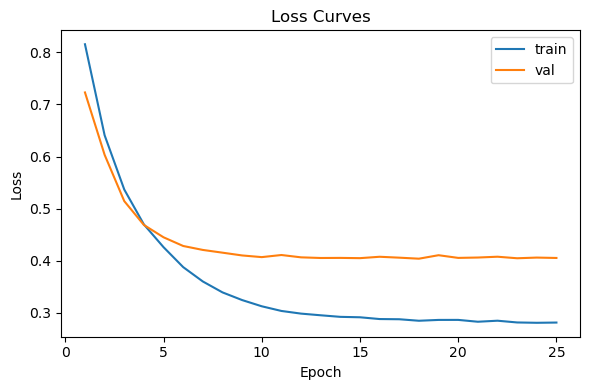

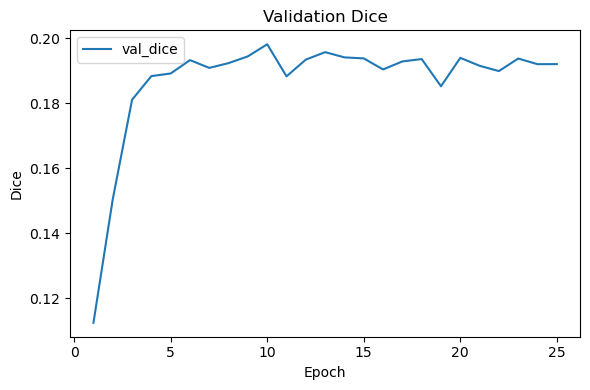

In [3]:
# # load ed_history from file
# import json
# with open(OUTPUT_DIR/'encdec_training_history.json', 'r') as f:
#     ed_history = json.load(f)


plt.figure(figsize=(6,4)); plt.plot(ed_history['epoch'], ed_history['train_loss'], label='train')
plt.plot(ed_history['epoch'], ed_history['val_loss'], label='val'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Curves'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(ed_history['epoch'], ed_history['val_dice'], label='val_dice')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Validation Dice'); plt.legend(); plt.tight_layout(); plt.show()

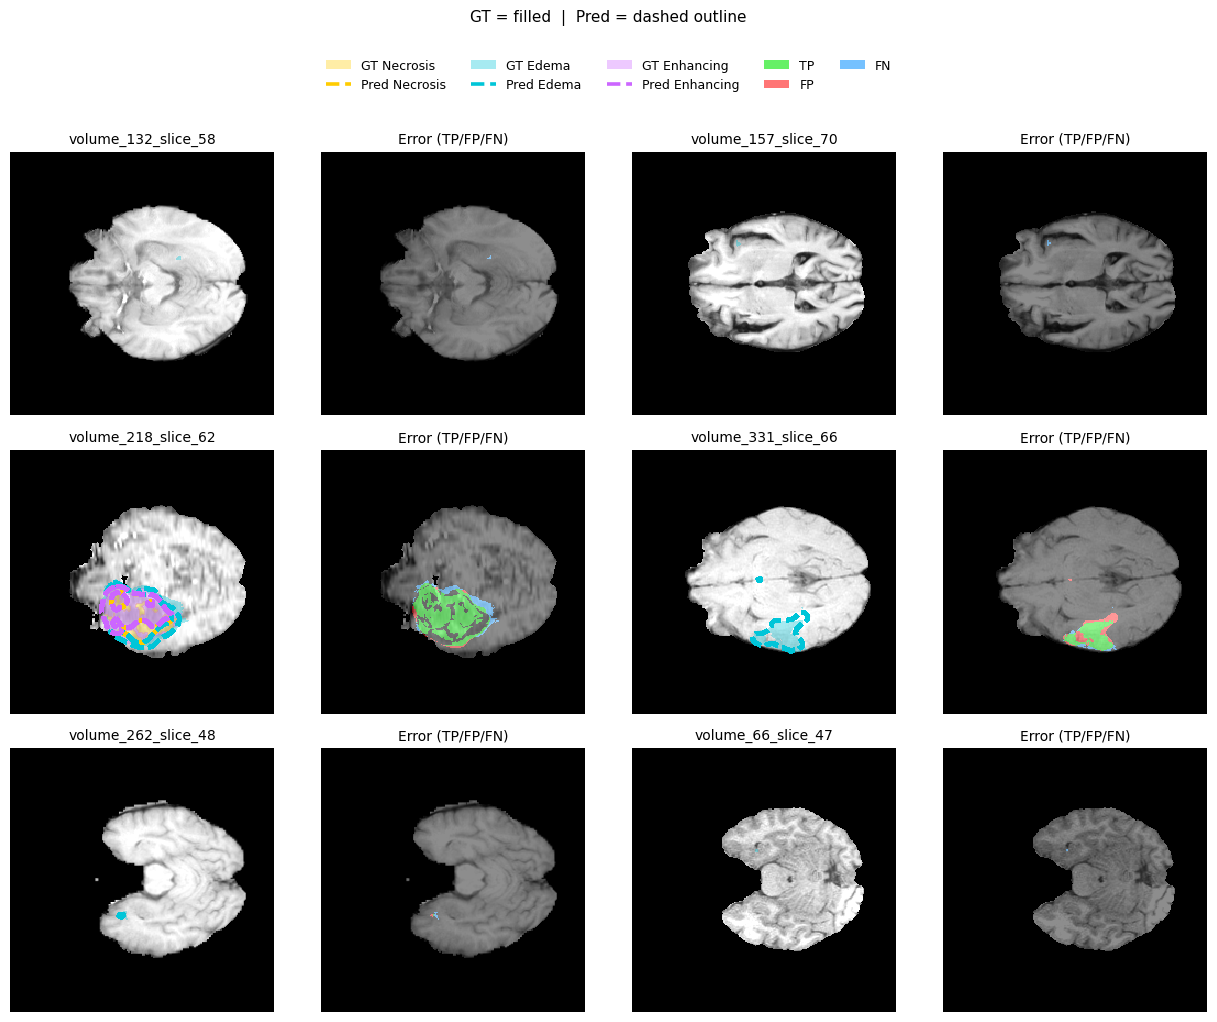

In [23]:
# encdec.load_state_dict(torch.load(OUTPUT_DIR/'encdec_best.pt', map_location=DEVICE))
encdec.eval()
# viz_overlays(val_ds, encdec, device=DEVICE, n=6, base_channel=1, seed=35)
viz_overlays_pro(val_ds, encdec, device=DEVICE, n=6, samples_per_row=2, show_error=True, base_channel=1, seed=35)

In [24]:
ed_slice,   ed_vol,   ed_overall = evaluate_multiclass(
    test_loader, encdec, device=DEVICE, add_overall_mean=True, save_csv_dir=OUTPUT_DIR, model_name="encdec"
)
print("Overall mean row:")
print(ed_overall)          # {'dice_Necrosis':..., 'dice_Edema':..., ..., 'volume_id':'Overall_Mean'}
display(ed_vol.tail(3))  # Overall_Mean

Overall mean row:
{'dice_Necrosis': 0.7758135162640231, 'iou_Necrosis': 0.7517859955612374, 'dice_Edema': 0.6876621903854343, 'iou_Edema': 0.6377875268067821, 'dice_Enhancing': 0.7598479508790208, 'iou_Enhancing': 0.7284335853423446, 'dice_FG_mean': 0.7411078858428259, 'iou_FG_mean': 0.7060023692367882, 'volume_id': 'Overall_Mean'}


,volume_id,dice_Necrosis,iou_Necrosis,dice_Edema,iou_Edema,dice_Enhancing,iou_Enhancing,dice_FG_mean,iou_FG_mean
35,volume_85,0.785544,0.770170,0.816234,0.758249,0.765638,0.738476,0.789139,0.755631
36,volume_94,0.933484,0.931695,0.696730,0.668980,0.887092,0.875926,0.839102,0.825533
37,Overall_Mean,0.775814,0.751786,0.687662,0.637788,0.759848,0.728434,0.741108,0.706002


---
## 3. Train 2D U-Net
### 3.1 Train 2D U-Net

1. Train a small 2D U-Net (4-channel input → 1-channel tumor mask)
2. Plot training curves & qualitative overlays
3. Evaluate on test set: Dice / IoU / 2D-HD95 (per-slice) and aggregate per-volume

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet2D(nn.Module):
    def __init__(self, in_ch=4, out_ch=1, base=32):
        super().__init__()
        self.d1 = DoubleConv(in_ch, base);  self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(base, base*2); self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(base*2, base*4); self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(base*4, base*8)
        self.u3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2); self.ud3 = DoubleConv(base*8, base*4)
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2); self.ud2 = DoubleConv(base*4, base*2)
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2);   self.ud1 = DoubleConv(base*2, base)
        self.outc = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.p1(x1))
        x3 = self.d3(self.p2(x2))
        x4 = self.d4(self.p3(x3))
        x = self.u3(x4); x = self.ud3(torch.cat([x, x3], dim=1))
        x = self.u2(x);  x = self.ud2(torch.cat([x, x2], dim=1))
        x = self.u1(x);  x = self.ud1(torch.cat([x, x1], dim=1))
        return self.outc(x)

model = UNet2D(in_ch=4, out_ch=4).to(DEVICE)
print(f'Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f} M')


Model params: 1.93 M


In [26]:
ce = nn.CrossEntropyLoss()  # logits: (B,4,H,W); target: (B,H,W) long

def soft_dice_mc(logits, target, eps=1e-6):
    """
    Multiclass soft Dice averaged over foreground classes (1..3).
    logits: (B,C,H,W), target: (B,H,W) long in [0..C-1]
    """
    probs = torch.softmax(logits, dim=1)               # (B,C,H,W)
    onehot = torch.zeros_like(probs)                   # (B,C,H,W)
    onehot.scatter_(1, target.unsqueeze(1), 1)         # GT one-hot

    # foreground only
    p = probs[:, 1:, :, :]                             # (B,3,H,W)
    t = onehot[:, 1:, :, :]
    inter = (p * t).sum(dim=(2,3)) * 2                 # (B,3)
    den   = (p*p + t*t).sum(dim=(2,3)) + eps           # (B,3)
    dice_per_class = inter / den                       # (B,3)
    return 1.0 - dice_per_class.mean()                 # scalar loss

def criterion(logits, target):
    return 0.5 * ce(logits, target) + 0.5 * soft_dice_mc(logits, target)


def iou_score(pred, target, th=0.5, eps=1e-6):
    pred = (pred>th).astype(np.uint8); target = (target>0.5).astype(np.uint8)
    inter = (pred & target).sum(); union = (pred | target).sum()
    return (inter + eps) / (union + eps)

def hd95_binary(pred, target):
    pred = pred.astype(bool); target = target.astype(bool)
    if pred.sum()==0 and target.sum()==0: return 0.0
    if pred.sum()==0 or target.sum()==0: return float('inf')
    P = np.column_stack(np.nonzero(pred)); T = np.column_stack(np.nonzero(target))
    D1 = cdist(P, T).min(axis=1); D2 = cdist(T, P).min(axis=1)
    d = np.concatenate([D1, D2])
    return float(np.percentile(d, 95))


In [27]:
def fg_macro_dice_from_logits(logits, y, num_classes=4, eps=1e-6):
    """
    logits: (B,C,H,W), y: (B,H,W) long
    return: scalar macro dice over classes 1..C-1
    """
    with torch.no_grad():
        pred = torch.argmax(logits, dim=1)          # (B,H,W)
        dices = []
        for c in range(1, num_classes):
            p = (pred == c).float()
            t = (y    == c).float()
            inter = (p*t).sum(dim=(1,2)) * 2
            den   = (p*p + t*t).sum(dim=(1,2)) + eps
            dices.append(inter / den)
        return torch.stack(dices, 0).mean().item()

# validation loop example
def validate(loader):
    model.eval(); total_loss, total_dice, n = 0.0, 0.0, 0
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(DEVICE); y = y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0); n += x.size(0)
            total_dice += fg_macro_dice_from_logits(logits, y) * x.size(0)
    return total_loss/max(1,n), total_dice/max(1,n)

In [28]:
history = {'epoch':[], 'train_loss':[], 'val_loss':[], 'val_dice':[]}

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def run_epoch(loader, train=True):
    total_loss, n = 0.0, 0
    model.train() if train else model.eval()
    for x, y, _ in loader:
        x = x.to(DEVICE); y = y.to(DEVICE)          # y: (B,H,W) long
        with torch.set_grad_enabled(train):
            logits = model(x)                       # (B,4,H,W)
            loss = criterion(logits, y)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0); n += x.size(0)
    return total_loss / max(1, n)



# best_val = 1e9
best_val = float('inf')
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va, vd = validate(val_loader)                

    history['epoch'].append(ep)
    history['train_loss'].append(tr)
    history['val_loss'].append(va)
    history['val_dice'].append(vd)

    print(f"[{ep:03d}] train_loss={tr:.4f}  val_loss={va:.4f}  val_dice={vd:.4f}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), OUTPUT_DIR/'unet2d_best.pt')
        print("  saved best ckpt")

# save history
import json
with open(OUTPUT_DIR/'unet2d_training_history.json', 'w') as f:
    json.dump(history, f)

# # load history from file
# with open(OUTPUT_DIR/'unet2d_training_history.json', 'r') as f:
#     history = json.load(f)


[001] train_loss=0.9078  val_loss=0.7889  val_dice=0.1224
  saved best ckpt
[002] train_loss=0.6682  val_loss=0.6013  val_dice=0.1880
  saved best ckpt
[003] train_loss=0.5399  val_loss=0.5125  val_dice=0.2064
  saved best ckpt
[004] train_loss=0.4607  val_loss=0.4478  val_dice=0.2229
  saved best ckpt
[005] train_loss=0.4063  val_loss=0.4351  val_dice=0.2038
  saved best ckpt
[006] train_loss=0.3615  val_loss=0.4056  val_dice=0.2291
  saved best ckpt
[007] train_loss=0.3246  val_loss=0.4018  val_dice=0.2208
  saved best ckpt
[008] train_loss=0.3033  val_loss=0.3909  val_dice=0.2316
  saved best ckpt
[009] train_loss=0.2925  val_loss=0.3925  val_dice=0.2272
[010] train_loss=0.2866  val_loss=0.3978  val_dice=0.2160
[011] train_loss=0.2822  val_loss=0.3897  val_dice=0.2226
  saved best ckpt
[012] train_loss=0.2792  val_loss=0.3934  val_dice=0.2183
[013] train_loss=0.2775  val_loss=0.3905  val_dice=0.2213
[014] train_loss=0.2755  val_loss=0.3857  val_dice=0.2308
  saved best ckpt
[015] tr

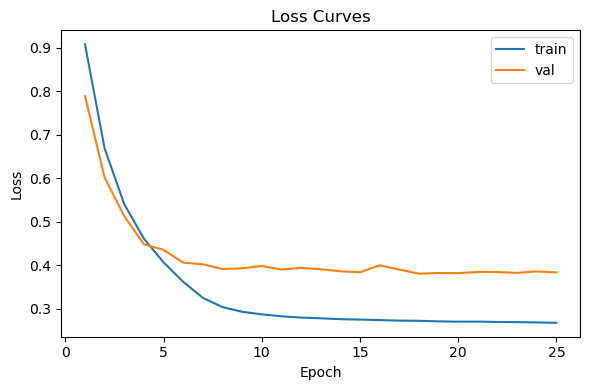

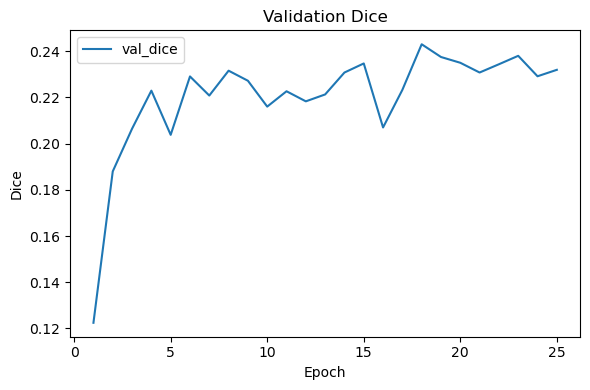

In [29]:
plt.figure(figsize=(6,4)); plt.plot(history['epoch'], history['train_loss'], label='train')
plt.plot(history['epoch'], history['val_loss'], label='val'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Curves'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(history['epoch'], history['val_dice'], label='val_dice')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Validation Dice'); plt.legend(); plt.tight_layout(); plt.show()




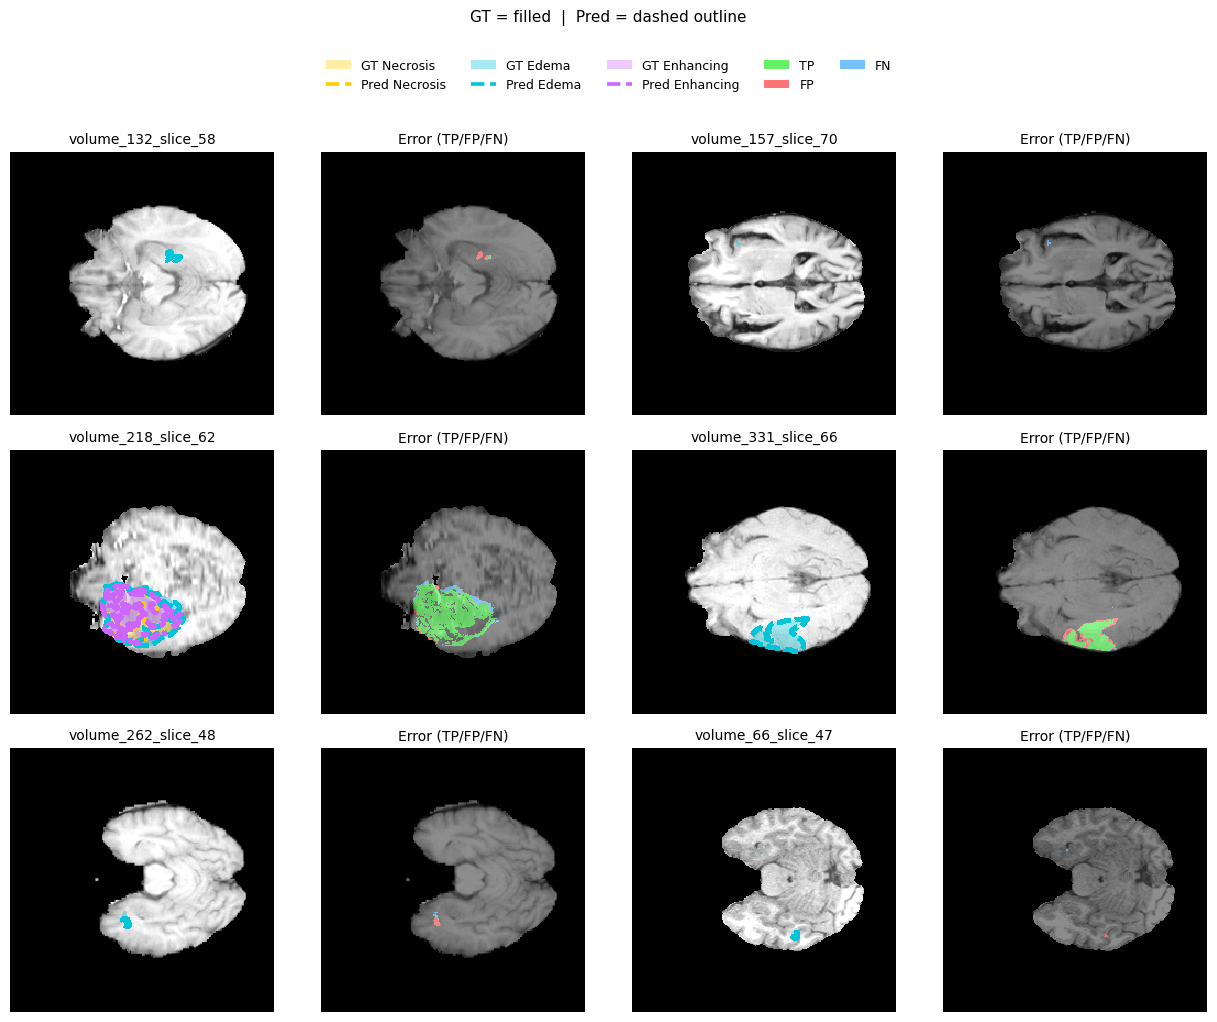

In [30]:
# model.load_state_dict(torch.load(OUTPUT_DIR/'unet2d_best.pt', map_location=DEVICE))
model.eval()
# viz_overlays(val_ds, model, device=DEVICE, n=6, base_channel=1, seed=35)
viz_overlays_pro(val_ds, model, device=DEVICE, n=6, samples_per_row=2, show_error=True, base_channel=1, seed=35)


In [31]:
unet_slice, unet_vol, unet_overall = evaluate_multiclass(
    test_loader, model, device=DEVICE, add_overall_mean=True, save_csv_dir=OUTPUT_DIR, model_name="unet"
)

print("Overall mean row:")
print(unet_overall)          # {'dice_Necrosis':..., 'dice_Edema':..., ..., 'volume_id':'Overall_Mean'}
display(unet_vol.tail(3))  # Overall_Mean


Overall mean row:
{'dice_Necrosis': 0.7591681637761781, 'iou_Necrosis': 0.7342291972937245, 'dice_Edema': 0.6723438174967933, 'iou_Edema': 0.625628412367178, 'dice_Enhancing': 0.7929294023009343, 'iou_Enhancing': 0.765475250107271, 'dice_FG_mean': 0.7414804611913017, 'iou_FG_mean': 0.7084442865893913, 'volume_id': 'Overall_Mean'}


,volume_id,dice_Necrosis,iou_Necrosis,dice_Edema,iou_Edema,dice_Enhancing,iou_Enhancing,dice_FG_mean,iou_FG_mean
35,volume_85,0.815500,0.795324,0.733006,0.686502,0.755989,0.729788,0.768165,0.737205
36,volume_94,0.928268,0.923790,0.777340,0.755041,0.927520,0.921270,0.877710,0.866700
37,Overall_Mean,0.759168,0.734229,0.672344,0.625628,0.792929,0.765475,0.741480,0.708444


---
### 3.2 Compare with Endode-Decode Model

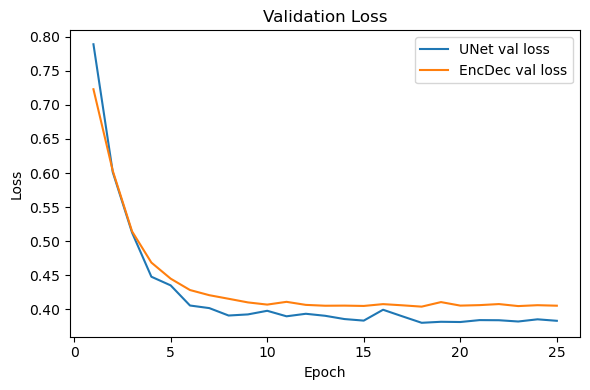

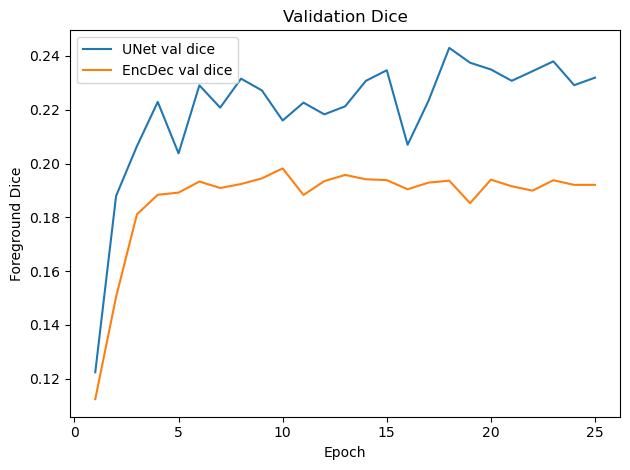

In [ ]:
import matplotlib.pyplot as plt
import json

# with open(OUTPUT_DIR/'unet2d_training_history.json', 'r') as f:
#     history = json.load(f)
# with open(OUTPUT_DIR/'encdec_training_history.json', 'r') as f:
#     ed_history = json.load(f)

plt.figure(figsize=(6,4))

plt.plot(history["epoch"], history["val_loss"], label="UNet val loss")
plt.plot(ed_history["epoch"], ed_history["val_loss"], label="EncDec val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.plot(history["epoch"], history["val_dice"], label="UNet val dice")
plt.plot(ed_history["epoch"], ed_history["val_dice"], label="EncDec val dice")
plt.xlabel("Epoch"); plt.ylabel("Foreground Dice"); plt.title("Validation Dice"); plt.legend(); plt.tight_layout(); plt.show()


In [41]:
# # Load UNet
# model = UNet2D(in_ch=in_channels, out_ch=num_classes).to(DEVICE)
# unetmodel_base.load_state_dict(torch.load(OUTPUT_DIR/"unet2d_best.pt", map_location=DEVICE))
# # Load best Encoder–Decoder
# encdec.load_state_dict(torch.load(OUTPUT_DIR/"encdec_best.pt", map_location=DEVICE))
# # Evaluate
# unet_slice, unet_vol, unet_overall = evaluate_multiclass(test_loader, model, device=DEVICE, model_name="unet")
# ed_slice,   ed_vol,   ed_overall   = evaluate_multiclass(test_loader, encdec,   device=DEVICE, model_name="encdec")

# Merge per-volume tables and append overall mean row
import pandas as pd
cmp = unet_vol.merge(ed_vol, on="volume_id", suffixes=("_unet","_encdec"))

if unet_overall and ed_overall:
    row = {"volume_id":"Overall_Mean"}
    for k,v in unet_overall.items():
        if k!="volume_id": row[f"{k}_unet"] = v
    for k,v in ed_overall.items():
        if k!="volume_id": row[f"{k}_encdec"] = v
    cmp = pd.concat([cmp, pd.DataFrame([row])], ignore_index=True)

cmp.to_csv(OUTPUT_DIR/"compare_unet_vs_encdec.csv", index=False)

display(cmp.iloc[[-1], 9:18])
display(cmp.iloc[[-1], 1:9])


,dice_Necrosis_encdec,iou_Necrosis_encdec,dice_Edema_encdec,iou_Edema_encdec,dice_Enhancing_encdec,iou_Enhancing_encdec,dice_FG_mean_encdec,iou_FG_mean_encdec
38,0.775814,0.751786,0.687662,0.637788,0.759848,0.728434,0.741108,0.706002


,dice_Necrosis_unet,iou_Necrosis_unet,dice_Edema_unet,iou_Edema_unet,dice_Enhancing_unet,iou_Enhancing_unet,dice_FG_mean_unet,iou_FG_mean_unet
38,0.759168,0.734229,0.672344,0.625628,0.792929,0.765475,0.74148,0.708444


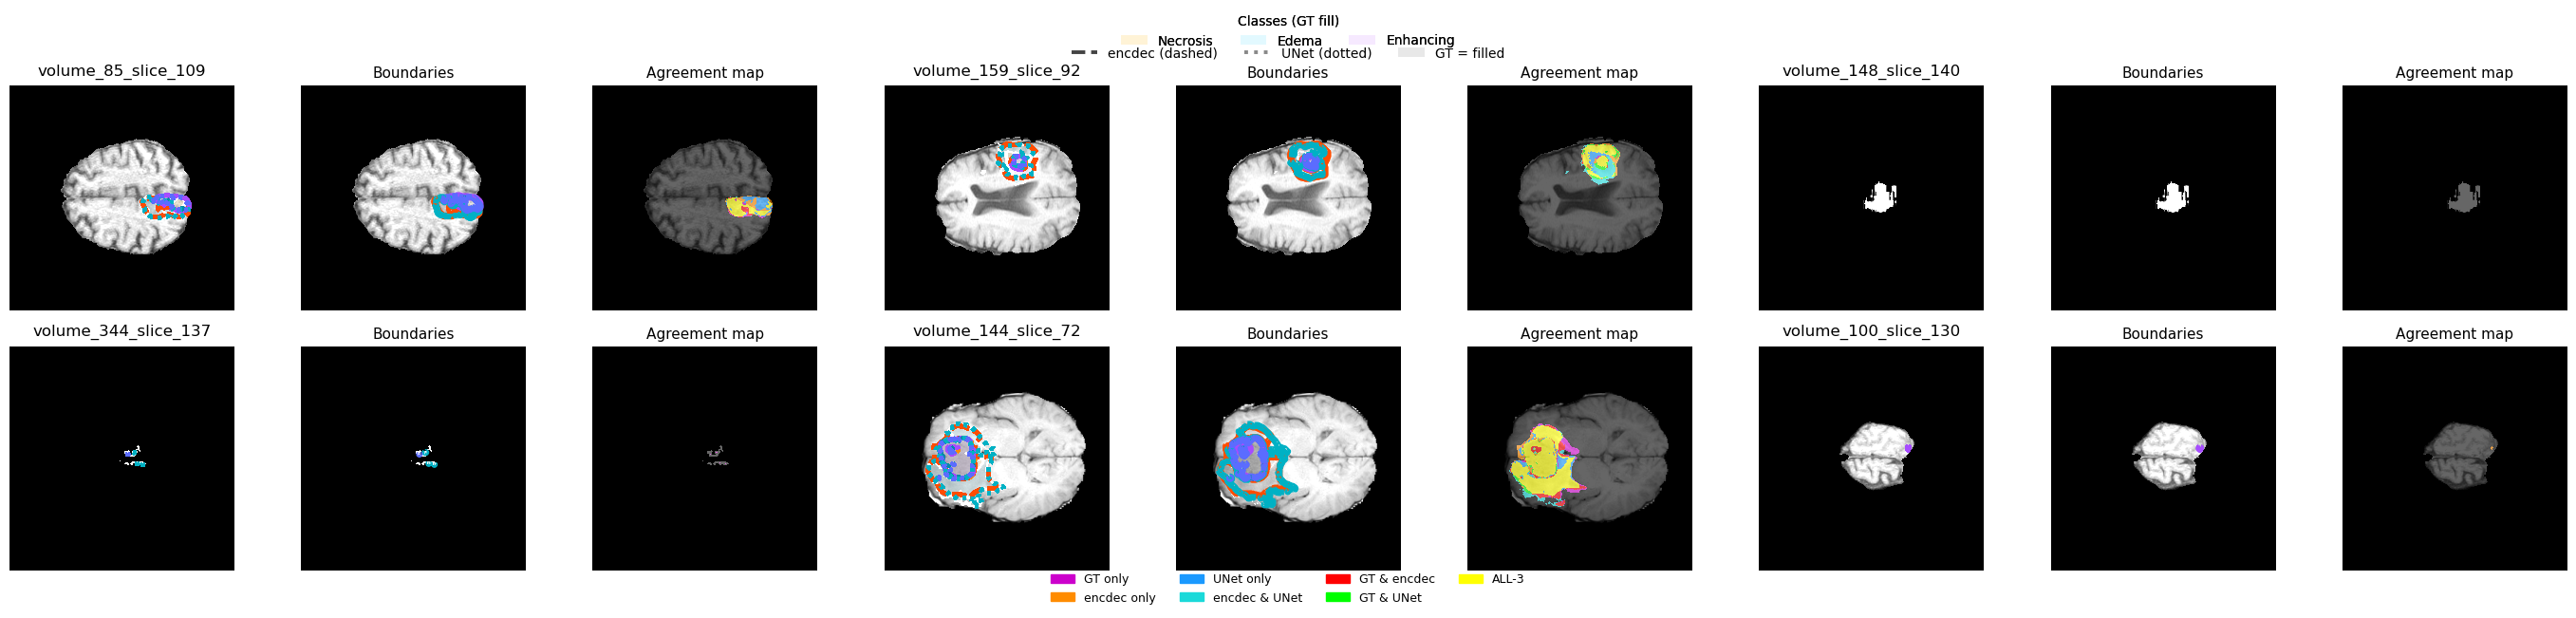

In [45]:
# viz_compare(test_ds, encdec, model, device=DEVICE, n=6, model1_name="encdec", model2_name="UNet")
viz_compare_diagnostic(
    test_ds,
    model_1=encdec,
    model_2=model,
    device=DEVICE,
    n=6,
    samples_per_row=3,
    base_channel=1,
    show_overlay=True,
    show_boundaries=True,
    show_agreement=True,
    model_1_name="encdec",
    model_2_name="UNet"
)


---
## 4. Fine-tune Transfer-learning UNet encoder
### 4.1 Fine-tune Transfer-learning UNet encoder

Build the Transfer-Learning U-Net (ImageNet encoder):

In [13]:

import segmentation_models_pytorch as smp
import torch.nn as nn
import torch

# Define number of input channels (modalities) and output classes
in_channels = 4   # T1, T1Gd, T2, FLAIR
num_classes = 4   # Background + 3 tumor subregions

# Create a U-Net with an ImageNet-pretrained encoder
tl_model = smp.Unet(
    encoder_name="resnet34",           # Common choices: resnet18/34/50, efficientnet-b0/b3, etc.
    encoder_weights="imagenet",        # Use ImageNet pretrained weights
    in_channels=in_channels,           # Four MRI modalities
    classes=num_classes,               # Four segmentation classes
    activation=None,                   # Output logits (for CE + SoftDice)
).to(DEVICE)

# Freeze encoder layers during warm-up stage
def freeze_encoder(m, flag=True):
    for p in m.encoder.parameters():
        p.requires_grad = not flag

# Freeze entire encoder for warm-up
freeze_encoder(tl_model, flag=True)


/home/holly520/miniforge3/envs/dml/lib/python3.11/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading resnet34 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)


Define losses and optimizers:

In [14]:
# Combined Cross-Entropy + Multi-class SoftDice Loss
ce = nn.CrossEntropyLoss()

def soft_dice_mc(logits, target, eps=1e-6):
    """
    Multi-class soft Dice loss (ignores background class).
    """
    probs  = torch.softmax(logits, dim=1)
    onehot = torch.zeros_like(probs)
    onehot.scatter_(1, target.unsqueeze(1), 1)
    p = probs[:, 1:]                           # foreground only
    t = onehot[:, 1:]
    inter = (p * t).sum(dim=(2,3)) * 2
    den   = (p*p + t*t).sum(dim=(2,3)) + eps
    return 1.0 - (inter / den).mean()

def criterion_tl(logits, y):
    return 0.5 * ce(logits, y) + 0.5 * soft_dice_mc(logits, y)

# Two-phase training: warm-up (decoder only) -> fine-tune (full model)
LR_TL = LR * 0.5
optim_warm = torch.optim.Adam(filter(lambda p: p.requires_grad, tl_model.parameters()), lr=LR_TL)
optim_ft   = torch.optim.Adam(tl_model.parameters(), lr=LR_TL * 0.5)

FT_EPOCHS = 16
warmup_epochs = 3
ft_epochs     = max(1, FT_EPOCHS - warmup_epochs)

use_amp = (DEVICE == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Training and validation loops:

In [15]:
def train_one_epoch_tl(model, loader, optimizer):
    """
    Train for one epoch using mixed precision.
    """
    model.train()
    total, n = 0.0, 0
    optimizer.zero_grad(set_to_none=True)
    for x, y, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion_tl(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / max(1, n)

@torch.no_grad()
def validate_tl(model, loader):
    """
    Validation pass: compute loss and macro foreground Dice.
    """
    model.eval()
    total, dice_sum, n = 0.0, 0.0, 0
    for x, y, _ in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion_tl(logits, y)
        total += loss.item() * x.size(0)
        n += x.size(0)

        pred = torch.argmax(logits, dim=1)
        dices = []
        for c in (1, 2, 3):  # foreground classes only
            p = (pred == c).float()
            t = (y == c).float()
            inter = (2 * (p * t).sum(dim=(1,2)))
            den   = ((p*p + t*t).sum(dim=(1,2)) + 1e-6)
            dices.append((inter / den).mean())
        dice_sum += torch.stack(dices).mean().item() * x.size(0)
    return total / max(1, n), dice_sum / max(1, n)


Stage-wise training: freeze and unfreeze:

In [ ]:
# ---- Stage 1: Train decoder only (encoder frozen)
hist_tl = {"epoch": [], "train_loss": [], "val_loss": [], "val_dice": []}
best_val = 1e9
for ep in range(1, warmup_epochs + 1):
    tr = train_one_epoch_tl(tl_model, train_loader, optim_warm)
    va, vd = validate_tl(tl_model, val_loader)
    hist_tl["epoch"].append(ep)
    hist_tl["train_loss"].append(tr)
    hist_tl["val_loss"].append(va)
    hist_tl["val_dice"].append(vd)
    print(f"[TL warm {ep:03d}] train={tr:.4f}  val={va:.4f}  dice={vd:.4f}")
    if va < best_val:
        best_val = va
        torch.save(tl_model.state_dict(), OUTPUT_DIR / "tl_best.pt")

# ---- Stage 2: Fine-tune all layers (unfreeze encoder)
freeze_encoder(tl_model, flag=False)
for ep in range(warmup_epochs + 1, warmup_epochs + ft_epochs + 1):
    tr = train_one_epoch_tl(tl_model, train_loader, optim_ft)
    va, vd = validate_tl(tl_model, val_loader)
    hist_tl["epoch"].append(ep)
    hist_tl["train_loss"].append(tr)
    hist_tl["val_loss"].append(va)
    hist_tl["val_dice"].append(vd)
    print(f"[TL ft   {ep:03d}] train={tr:.4f}  val={va:.4f}  dice={vd:.4f}")
    if va < best_val:
        best_val = va
        torch.save(tl_model.state_dict(), OUTPUT_DIR / "tl_best.pt")

# save history
import json
with open(OUTPUT_DIR / "tl_training_history.json", "w") as f:
    json.dump(hist_tl, f)


/home/holly520/miniforge3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


[TL warm 001] train=0.8372  val=0.6635  dice=0.0749
[TL warm 002] train=0.5876  val=0.5212  dice=0.1740
[TL warm 003] train=0.4629  val=0.4538  dice=0.1882
[TL ft   004] train=0.4039  val=0.4193  dice=0.2074
[TL ft   005] train=0.3685  val=0.4066  dice=0.2055
[TL ft   006] train=0.3432  val=0.3988  dice=0.2097
[TL ft   007] train=0.3250  val=0.3969  dice=0.2111
[TL ft   008] train=0.3123  val=0.3972  dice=0.2127
[TL ft   009] train=0.3016  val=0.3969  dice=0.2075
[TL ft   010] train=0.2931  val=0.3954  dice=0.2146
[TL ft   011] train=0.2872  val=0.3942  dice=0.2134
[TL ft   012] train=0.2835  val=0.3944  dice=0.2156
[TL ft   013] train=0.2813  val=0.3923  dice=0.2188
[TL ft   014] train=0.2792  val=0.3953  dice=0.2153
[TL ft   015] train=0.2777  val=0.3928  dice=0.2169
[TL ft   016] train=0.2764  val=0.3930  dice=0.2192


NameError: name 'json' is not defined

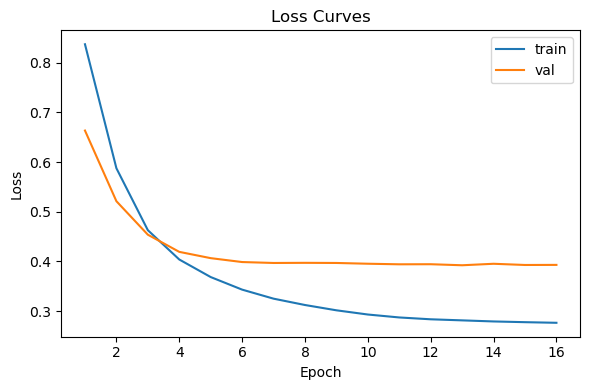

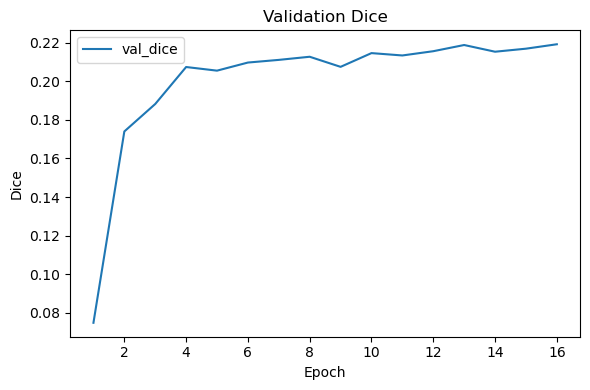

In [18]:
plt.figure(figsize=(6,4)); plt.plot(hist_tl['epoch'], hist_tl['train_loss'], label='train')
plt.plot(hist_tl['epoch'], hist_tl['val_loss'], label='val'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Curves'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(hist_tl['epoch'], hist_tl['val_dice'], label='val_dice')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Validation Dice'); plt.legend(); plt.tight_layout(); plt.show()

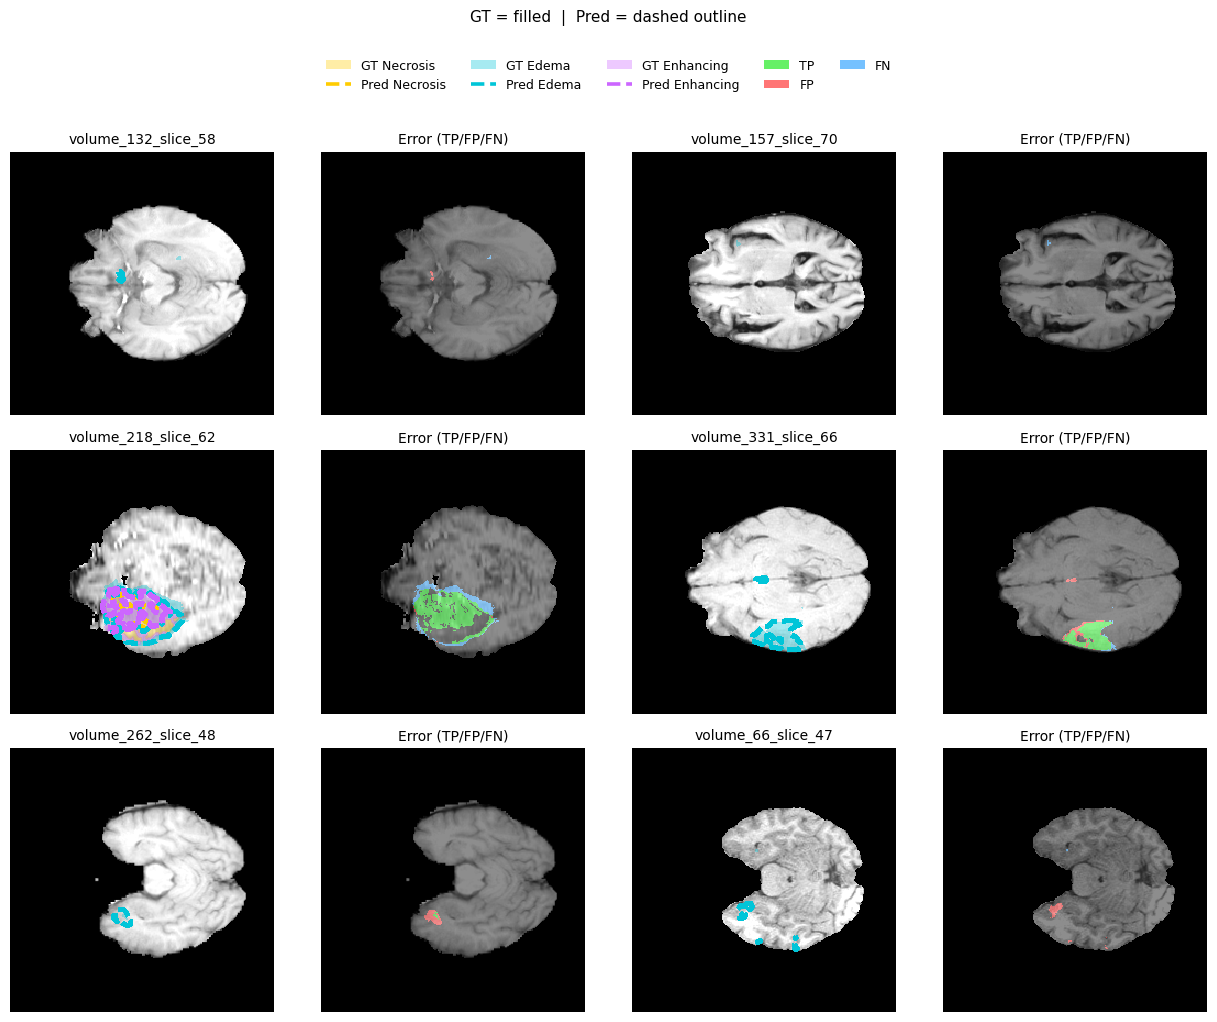

In [19]:
# tl_model.load_state_dict(torch.load(OUTPUT_DIR/'tl_best.pt', map_location=DEVICE))
tl_model.eval()
# viz_overlays_pro(val_ds, tl_model, device=DEVICE, n=6, samples_per_row=3, base_channel=1, seed=35)
viz_overlays_pro(val_ds, tl_model, device=DEVICE, n=6, samples_per_row=2, show_error=True, base_channel=1, seed=35)

In [20]:
tl_slice, tl_vol, tl_overall = evaluate_multiclass(
    test_loader, tl_model, device=DEVICE, add_overall_mean=True, save_csv_dir=OUTPUT_DIR, model_name="tl_unet"
)

print("Overall mean row:")
print(tl_overall)          # {'dice_Necrosis':..., 'dice_Edema':..., ..., 'volume_id':'Overall_Mean'}
display(tl_vol.tail(3))  # Overall_Mean

Overall mean row:
{'dice_Necrosis': 0.7070558365902895, 'iou_Necrosis': 0.6814278619690386, 'dice_Edema': 0.5245680885461819, 'iou_Edema': 0.47473545516536075, 'dice_Enhancing': 0.71200149570227, 'iou_Enhancing': 0.6822116638544774, 'dice_FG_mean': 0.6478751402795805, 'iou_FG_mean': 0.6127916603296258, 'volume_id': 'Overall_Mean'}


,volume_id,dice_Necrosis,iou_Necrosis,dice_Edema,iou_Edema,dice_Enhancing,iou_Enhancing,dice_FG_mean,iou_FG_mean
35,volume_85,0.705495,0.685409,0.509421,0.458846,0.664932,0.637869,0.626616,0.594042
36,volume_94,0.924941,0.919932,0.737049,0.713786,0.894569,0.885404,0.852186,0.839707
37,Overall_Mean,0.707056,0.681428,0.524568,0.474735,0.712001,0.682212,0.647875,0.612792


---
### 4.2 Compare with U-Net

Quantitative evaluation and comparison:

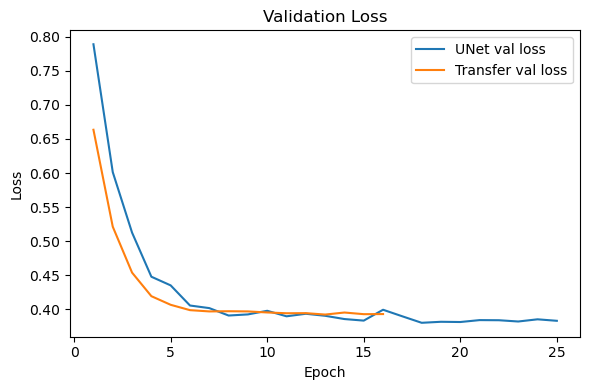

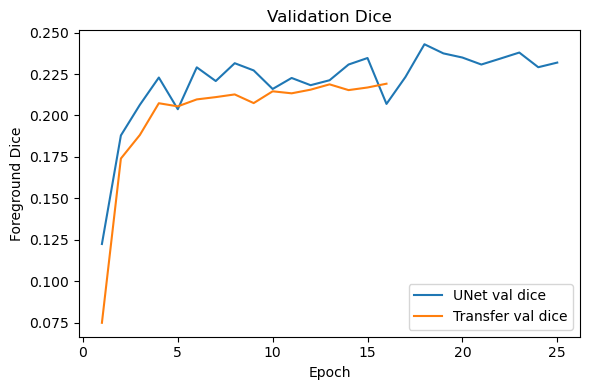

In [21]:
import matplotlib.pyplot as plt

with open(OUTPUT_DIR/'unet2d_training_history.json', 'r') as f:
    history = json.load(f)
# with open(OUTPUT_DIR/'tl_training_history.json', 'r') as f:
#     hist_tl = json.load(f)


plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["val_loss"], label="UNet val loss")
plt.plot(hist_tl["epoch"], hist_tl["val_loss"], label="Transfer val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["val_dice"], label="UNet val dice")
plt.plot(hist_tl["epoch"], hist_tl["val_dice"], label="Transfer val dice")
plt.xlabel("Epoch"); plt.ylabel("Foreground Dice"); plt.title("Validation Dice"); plt.legend(); plt.tight_layout(); plt.show()

Qualitative visualization (UNet vs Transfer vs Ground Truth):

In [25]:
# UNet model
model = UNet2D(in_ch=in_channels, out_ch=num_classes).to(DEVICE)
model.load_state_dict(torch.load(OUTPUT_DIR/"unet2d_best.pt", map_location=DEVICE))
unet_slice, unet_vol, unet_overall = evaluate_multiclass(test_loader, model, device=DEVICE, model_name="unet")
# # Transfer model
# tl_model.load_state_dict(torch.load(OUTPUT_DIR/"tl_best.pt", map_location=DEVICE))
# tl_slice, tl_vol, tl_overall = evaluate_multiclass(test_loader, tl_model, device=DEVICE, model_name="tl_unet")


# Merge and compute per-volume + overall comparison
metric_cols = [c for c in tl_vol.columns if c != "volume_id"]
cmp = unet_vol.merge(tl_vol, on="volume_id", suffixes=("_unet", "_tl"))



if unet_overall and tl_overall:
    row = {"volume_id": "Overall_Mean"}
    for k, v in unet_overall.items():
        if k != "volume_id": row[f"{k}_unet"] = v
    for k, v in tl_overall.items():
        if k != "volume_id": row[f"{k}_tl"] = v
    import pandas as pd
    cmp = pd.concat([cmp, pd.DataFrame([row])], ignore_index=True)

cmp.to_csv(OUTPUT_DIR/"compare_unet_vs_TL.csv", index=False)
display(cmp.iloc[[-1], 9:18])
display(cmp.iloc[[-1], 1:9])


,dice_Necrosis_tl,iou_Necrosis_tl,dice_Edema_tl,iou_Edema_tl,dice_Enhancing_tl,iou_Enhancing_tl,dice_FG_mean_tl,iou_FG_mean_tl
38,0.707056,0.681428,0.524568,0.474735,0.712001,0.682212,0.647875,0.612792


,dice_Necrosis_unet,iou_Necrosis_unet,dice_Edema_unet,iou_Edema_unet,dice_Enhancing_unet,iou_Enhancing_unet,dice_FG_mean_unet,iou_FG_mean_unet
38,0.751609,0.727258,0.603648,0.55655,0.743128,0.715386,0.699462,0.666398


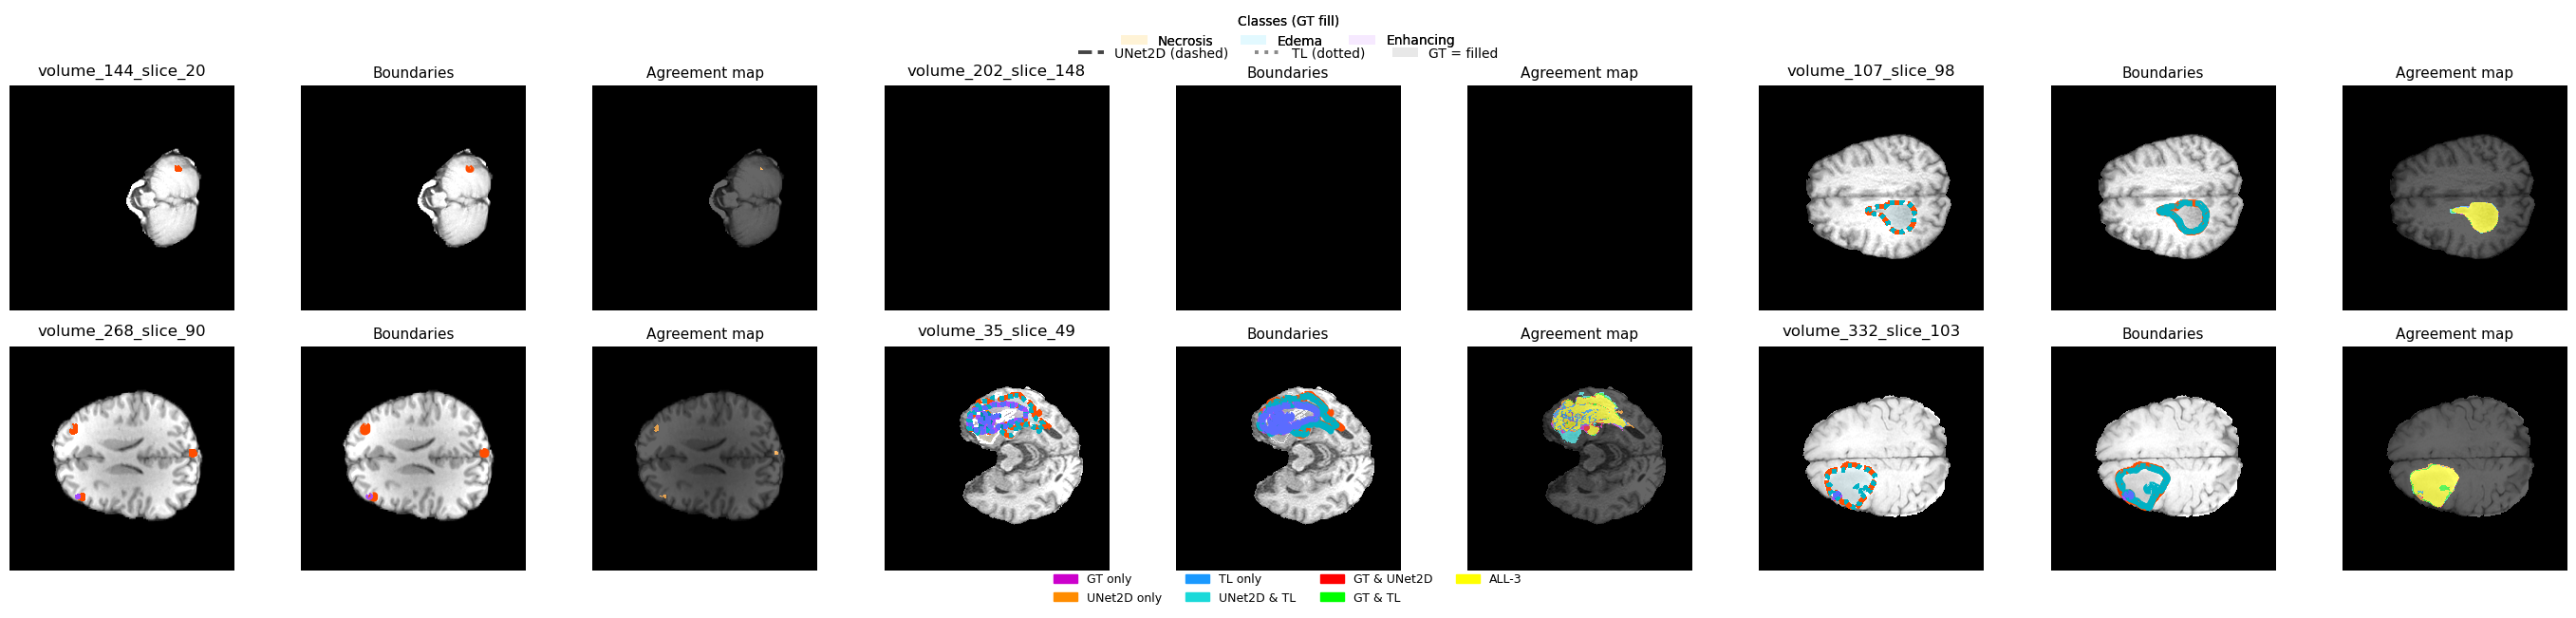

In [31]:
# viz_compare(test_ds, model, tl_model, device=DEVICE, n=6, model1_name="UNet", model2_name="TL")
# viz_compare_triplet(
#     test_ds,
#     model1=model,            # dashed
#     model2=tl_model,               # dotted (or tl_model)
#     device=DEVICE,
#     n=6,
#     samples_per_row=3,
#     base_channel=1,              # e.g., T1Gd
#     title1="UNet",
#     title2="TL"
# )

viz_compare_diagnostic(
    test_ds,
    model_1=model,
    model_2=tl_model,
    device=DEVICE,
    n=6,
    samples_per_row=3,
    base_channel=1,
    show_overlay=True,
    show_boundaries=True,
    show_agreement=True,
    model_1_name="UNet2D",
    model_2_name="TL",
)
